# Twitter Sentiment Analysis

In [59]:
# utilities
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) 
import re
import os
import pickle

# plotting and visualizing
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns


# sklearn

 # classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

 # metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix

 # pipeline
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

In [60]:
path = "/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv"
df = pd.read_csv(path, header = None)

### We are giving columns names

In [61]:
df.columns = ["target", "ids", "date", "flag", "user", "text"]

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


### If our machine is not powerful we don't have to take all the data. We can take the quarter of the data

In [ ]:
#df_pos = df[df['label'] == 4]
#df_neg = df[df['label'] == 0]

#df_pos = df_pos.iloc[:int(len(df_pos)/4)]
#df_neg = df_neg.iloc[:int(len(df_neg)/4)]

#df = pd.concat([df_pos, df_neg])

# shuffling the dataframe
#df = df.sample(frac = 1)

# Exploratory Data Analysis

In [63]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [64]:
df.sample(10)

,target,ids,date,flag,user,text
398902,0,2057009395,Sat Jun 06 12:12:09 PDT 2009,NO_QUERY,DKJ63,@waymonhudson I was shocked to read what @SOCM...
1254992,4,1997197642,Mon Jun 01 16:25:37 PDT 2009,NO_QUERY,peaceassailant,"@DaveJMatthews watched the CBS segment, and th..."
1515412,4,2175600071,Mon Jun 15 01:26:57 PDT 2009,NO_QUERY,HannahRose13,I love it when commercials for the CMT Music A...
1332853,4,2016304483,Wed Jun 03 06:32:33 PDT 2009,NO_QUERY,Cisnefeo,off to class wish me luck and a hope for all o...
1201865,4,1985752361,Sun May 31 17:42:21 PDT 2009,NO_QUERY,Pinkbuni,yesss! finally strawberry kiwi capri suns and ...
159735,0,1956907124,Thu May 28 23:00:03 PDT 2009,NO_QUERY,MrStarky,I hate homework
405357,0,2058668394,Sat Jun 06 15:23:45 PDT 2009,NO_QUERY,duskmisinki,@GirlNumberThree: Aww that sucks
422629,0,2062689964,Sat Jun 06 23:59:49 PDT 2009,NO_QUERY,brieface,@devimab I'm drying it out so I seriously hope...
1329560,4,2015681805,Wed Jun 03 05:16:24 PDT 2009,NO_QUERY,mmadeleines,@tommcfly COME TO SWEDEN
1245521,4,1995105218,Mon Jun 01 12:57:34 PDT 2009,NO_QUERY,MaAnMujunkie,"@BarelySeeAtAll *pats* It's okay, confusion is..."


In [65]:
df.shape

(1600000, 6)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='target', ylabel='count'>

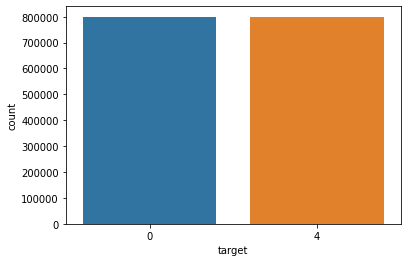

In [66]:
sns.countplot(df["target"])

- There are same numbers of target. The dataset is balanced.

# NLP Preprocessing

In [67]:
df["text"].iloc[0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [68]:
df["text"].iloc[1]

"is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"

### Here we are doing preprocessing, we are cleaning the text. First we define stop_words list, stemmer and cleaning regex expression. After we do the following: first we clean the text with cleaning regex expression and we converted all text to lowercase. After we use strip() function to delete line breaks (\n). Then we define a empty tokens list. We go over text and tokenize the text. And if token not in stop_words list we take the token and append to the tokens list. And if stem = True is given to us in function calling, we stem the token. Finally we join the tokens and make it a sentence.

In [69]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

cleaning = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(cleaning, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

### We can do better preprocessing. For example, we can turn some daily chatting language to official language like "u" to "you" "2day" to "today" etc
### Or we can turn smile emojis to meaningful word. For example ":)" to "smile"
### Or we can turn "she's" to "she is", "we've" to "we have" etc to get better result

In [70]:
df.text = df.text.apply(lambda x: preprocess(x, stem = True))

### We've eliminated accents

In [71]:
from unicodedata import normalize
df["text"] = df["text"].apply(lambda text: normalize("NFKD", str(text)).encode("ascii", "ignore").decode("utf-8", "ignore"))

### We are turning the labeling to "negative" and "positive"

In [72]:
df["target"] = df["target"].map({0: "negative", 4: "positive"})

### We are doing label encoding, giving positives to 1 and negatives to 0

In [73]:
le = LabelEncoder()
le.fit(df['target'])

df['target'] = le.transform(df['target'])

### We are deciding x and y and we split it to x_train and x_test

In [74]:
x = df.text

y = df.target

print(x.shape, y.shape) 

x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=42)

(1600000,) (1600000,)


In [75]:
df

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset updat facebook text might cri result sch...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dive mani time ball manag save 50 rest go bound
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole bodi feel itchi like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behav mad see
...,...,...,...,...,...,...
1599995,1,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,woke school best feel ever
1599996,1,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,thewdb com cool hear old walt interview
1599997,1,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,readi mojo makeov ask detail
1599998,1,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,happi 38th birthday boo alll time tupac amaru ...


# Predicting and Modeling

### Evaluating Function

In [76]:
def evaluate(model, vect):
    model.fit(x_train_dtm, y_train)
    y_pred = model.predict(x_test_dtm)
    print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))
    print("F1 Score: ", metrics.f1_score(y_test, y_pred))
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred)) 

### Vectorizing and transforming x_train and x_test

In [77]:
count_vect = CountVectorizer(ngram_range = (1,2), min_df = 2)
tfidf_vect = TfidfVectorizer(ngram_range = (1,2), min_df = 2)

x_train_dtm = count_vect.fit_transform(x_train)
x_test_dtm = count_vect.transform(x_test)

x_train_dtm = tfidf_vect.fit_transform(x_train)
x_test_dtm = tfidf_vect.transform(x_test)

### Defining the Models and Evaluating

In [78]:
MNB = MultinomialNB()
LSVC = LinearSVC()
LR = LogisticRegression(C = 2, max_iter = 1000)

print("Count Vectorizer: \n")
print("Multinomial Classfier: \n")
evaluate(MNB, count_vect)
print("\n")
print("Linear SVC Classfier: \n")
evaluate(LSVC, count_vect)
print("\n")
print("Logistic Regression Classfier: \n")
evaluate(LR, count_vect)

print("\n")
print("Tfidf Vectorizer: \n")
print("Multinomial Classfier: \n")
evaluate(MNB, tfidf_vect)
print("\n")
print("Linear SVC Classfier: \n")
evaluate(LSVC, tfidf_vect)
print("\n")
print("Logistic Regression Classfier: \n")
evaluate(LR, tfidf_vect)

Count Vectorizer: 

Multinomial Classfier: 

Accuracy:  0.77424
F1 Score:  0.7737206889812119
Confusion Matrix: 
 [[155307  44274]
 [ 46030 154389]]


Linear SVC Classfier: 

Accuracy:  0.773075
F1 Score:  0.7764538993119007
Confusion Matrix: 
 [[151592  47989]
 [ 42781 157638]]


Logistic Regression Classfier: 

Accuracy:  0.7893775
F1 Score:  0.7928651333177621
Confusion Matrix: 
 [[154508  45073]
 [ 39176 161243]]


Tfidf Vectorizer: 

Multinomial Classfier: 

Accuracy:  0.77424
F1 Score:  0.7737206889812119
Confusion Matrix: 
 [[155307  44274]
 [ 46030 154389]]


Linear SVC Classfier: 

Accuracy:  0.773075
F1 Score:  0.7764538993119007
Confusion Matrix: 
 [[151592  47989]
 [ 42781 157638]]


Logistic Regression Classfier: 

Accuracy:  0.7893775
F1 Score:  0.7928651333177621
Confusion Matrix: 
 [[154508  45073]
 [ 39176 161243]]


### When evaluating the sentiment (positive, negative, neutral) of a given text document, research shows that human analysts tend to agree around 80-85% of the time. This is the baseline we (usually) try to meet or beat when we’re training a sentiment scoring system. So we achieved %79 accuracy which is very good.

In [79]:
x_train_dtm.shape, x_test_dtm.shape

((1200000, 747387), (400000, 747387))

# Creating Wordcloud

In [80]:
def create_wordcloud(text):
    stopwords = set(STOPWORDS)
    wc = WordCloud(max_words = 25000, stopwords = stopwords)
    wc.generate(str(text))
    wc.to_file("wordcloud.png")
    print("Word Cloud saved successfully")
    path = "wordcloud.png"
    display(Image.open(path))

Word Cloud saved successfully


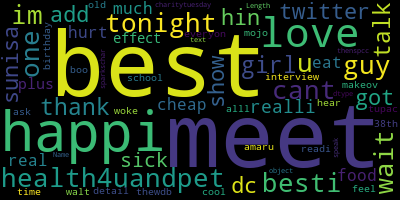

In [81]:
create_wordcloud(df[df["target"] == 1].text) # positive

Word Cloud saved successfully


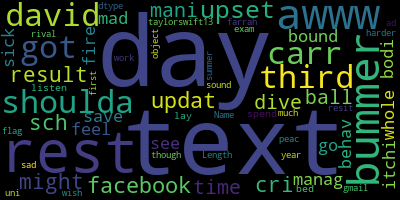

In [82]:
create_wordcloud(df[df["target"] == 0].text) # negative

# Creating Pipeline

In [83]:
model = Pipeline([("vectorizer", count_vect), ("classifier", LR)])
model.fit(x_train, y_train)
pred = model.predict(x_test)
confusion_matrix(pred, y_test)

array([[151283,  40561],
       [ 48298, 159858]])

In [84]:
def predict(sentence):
    if model.predict(sentence) == 0:
        print("negative")
    else:
        print("positive")

In [85]:
ex = ["It is so nice"]

predict(ex)

positive


# Saving the best Model

In [86]:
with open("model_pickle", "wb") as f:
    pickle.dump(LR, f)

# Loading the Model

In [87]:
with open("model_pickle", "rb") as f:
    loaded_model = pickle.load(f)

In [88]:
loaded_model.predict(x_test_dtm)

array([0, 1, 0, ..., 1, 1, 1])

### As you can see, we could save the model and load the model and use it